In [1]:
from pyspark.sql import SparkSession

# On arrête toute session existante au cas où
SparkSession.builder.getOrCreate().stop()

# On recrée la session avec le package Postgres
spark = SparkSession.builder \
    .appName("Taxi_Project") \
    .config("spark.jars.packages", "org.postgresql:postgresql:42.7.2") \
    .getOrCreate()

print("Spark est prêt avec le driver Postgres !")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/16 12:38:37 WARN Utils: Your hostname, Assma, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/01/16 12:38:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/16 12:38:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark est prêt avec le driver Postgres !


In [2]:
# import pyspark
# from pyspark.sql import SparkSession 

# spark = SparkSession.builder.appName('Taxi ETA ML').getOrCreate()
# spark

In [3]:
from pyspark.sql.functions import col, sum, avg, unix_timestamp, hour, dayofweek, month
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
df = spark.read.parquet("../data/Bronze_taxi.parquet")

In [5]:
print(f"Nombre de lignes : {df.count()}")
print(f"Nombre de colonnes : {len(df.columns)}")

Nombre de lignes : 3475226
Nombre de colonnes : 20


In [6]:
df.show()
df.printSchema()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2025-01-01 00:18:38|  2025-01-01 00:26:59|              1|          1.6|         1|                 N|         229|    

In [7]:
df.describe().show()

26/01/16 12:40:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-------

In [8]:
df.dtypes

[('VendorID', 'int'),
 ('tpep_pickup_datetime', 'timestamp_ntz'),
 ('tpep_dropoff_datetime', 'timestamp_ntz'),
 ('passenger_count', 'bigint'),
 ('trip_distance', 'double'),
 ('RatecodeID', 'bigint'),
 ('store_and_fwd_flag', 'string'),
 ('PULocationID', 'int'),
 ('DOLocationID', 'int'),
 ('payment_type', 'bigint'),
 ('fare_amount', 'double'),
 ('extra', 'double'),
 ('mta_tax', 'double'),
 ('tip_amount', 'double'),
 ('tolls_amount', 'double'),
 ('improvement_surcharge', 'double'),
 ('total_amount', 'double'),
 ('congestion_surcharge', 'double'),
 ('Airport_fee', 'double'),
 ('cbd_congestion_fee', 'double')]

In [9]:
# Vérifier les vals nulls

null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

null_counts.show(truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|0       |0                   |0                    |540149         |0            |540149    |540149            |0           |0   

In [10]:
#vérifier le nombre de ligne avant nett

row_count = df.count()
print("Number of rows: ", row_count)

Number of rows:  3475226


In [11]:
#supp les vals nulls

df = df.dropna()

In [12]:
#vérification

null_counts = df.select([
    sum(col(c).isNull().cast("int")).alias(c)
    for c in df.columns
])

null_counts.show(truncate=False)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|0       |0                   |0                    |0              |0            |0         |0                 |0           |0   

In [13]:
#vérifier le nombre de ligne aprés nett

row_count1 = df.count()
print("Number of rows: ", row_count1)

Number of rows:  2935077


In [14]:
#ajouter la colonne de Durée du trajet

df = df.withColumn(
    "duration_minutes",
    (unix_timestamp(col("tpep_dropoff_datetime")) -
     unix_timestamp(col("tpep_pickup_datetime"))) / 60
)

In [15]:
#vérification

df.select("tpep_pickup_datetime", "tpep_dropoff_datetime", "duration_minutes").show(5)


+--------------------+---------------------+-----------------+
|tpep_pickup_datetime|tpep_dropoff_datetime| duration_minutes|
+--------------------+---------------------+-----------------+
| 2025-01-01 00:18:38|  2025-01-01 00:26:59|             8.35|
| 2025-01-01 00:32:40|  2025-01-01 00:35:13|             2.55|
| 2025-01-01 00:44:04|  2025-01-01 00:46:01|             1.95|
| 2025-01-01 00:14:27|  2025-01-01 00:20:01|5.566666666666666|
| 2025-01-01 00:21:34|  2025-01-01 00:25:06|3.533333333333333|
+--------------------+---------------------+-----------------+
only showing top 5 rows


In [16]:
#Filtrage trajets aberrants :
# Distance ≤ 0 ou > 200 miles
# Durée ≤ 0 minutes
# Passagers ≤ 0
df = df.filter(
    (col("duration_minutes") > 0) |
    (col("trip_distance") > 0) |
    (col("trip_distance") < 200) |
    (col("passenger_count") > 0) 
)


In [17]:
df.describe().show()

+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+------------------+--------------------+-------------------+-------------------+-------------------+
|summary|           VendorID|   passenger_count|     trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|   duration_minutes|
+-------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+

In [18]:
df = df.filter(
    (col("trip_distance") >= 0.1) & (col("trip_distance") <= 50) &
    
    # Montants positifs
    (col("fare_amount") >= 2.5) & (col("fare_amount") < 200) &
    (col("total_amount") >= 3) & (col("total_amount") < 250) &
    
    
    (col("tip_amount") <= 100) &
    
    # Tolls: max $50
    (col("tolls_amount") <= 50) &
    
    # Nombre de passagers raisonnable
    (col("passenger_count") > 0) & (col("passenger_count") <= 6) &
    
    # Durée du trajet cohérente
    (unix_timestamp(col("tpep_dropoff_datetime")) > 
     unix_timestamp(col("tpep_pickup_datetime")))
)

In [19]:
numerical_cols = [
    'passenger_count','trip_distance', 'PULocationID', 'DOLocationID',
    'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge','total_amount','congestion_surcharge',
    'Airport_fee','cbd_congestion_fee','duration_minutes'  
]

df_numerical = df.select(numerical_cols)
df_numerical.summary("count", "min", "25%", "50%", "75%", "max").show()


+-------+---------------+-------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+--------------------+
|summary|passenger_count|trip_distance|PULocationID|DOLocationID|fare_amount|  extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|    duration_minutes|
+-------+---------------+-------------+------------+------------+-----------+-------+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+--------------------+
|  count|        2806818|      2806818|     2806818|     2806818|    2806818|2806818|2806818|   2806818|     2806818|              2806818|     2806818|             2806818|    2806818|           2806818|             2806818|
|    min|              1|          0.1|           1|           1|        2.5|    0.0|    0.0|   

In [20]:
df = df \
    .withColumn("pickup_hour", hour(col("tpep_pickup_datetime"))) \
    .withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime"))) \
    .withColumn("month", month(col("tpep_pickup_datetime")))


In [21]:
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+-----------+-----+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|  duration_minutes|pickup_hour|day_of_week|month|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+------------------+-----------+--

In [22]:
df = df.drop(
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime"
)


In [23]:
df.show(5)

+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+-----------+-----------+-----+
|VendorID|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee| duration_minutes|pickup_hour|day_of_week|month|
+--------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+-----------------+-----------+-----------+-----+
|       1|              1|          1.6|         1|                 N|         229|         237|           1|      

In [24]:

assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="features"
)

df_vector = assembler.transform(df).select("features")

In [25]:

corr_matrix = Correlation.corr(df_vector, "features", "pearson")

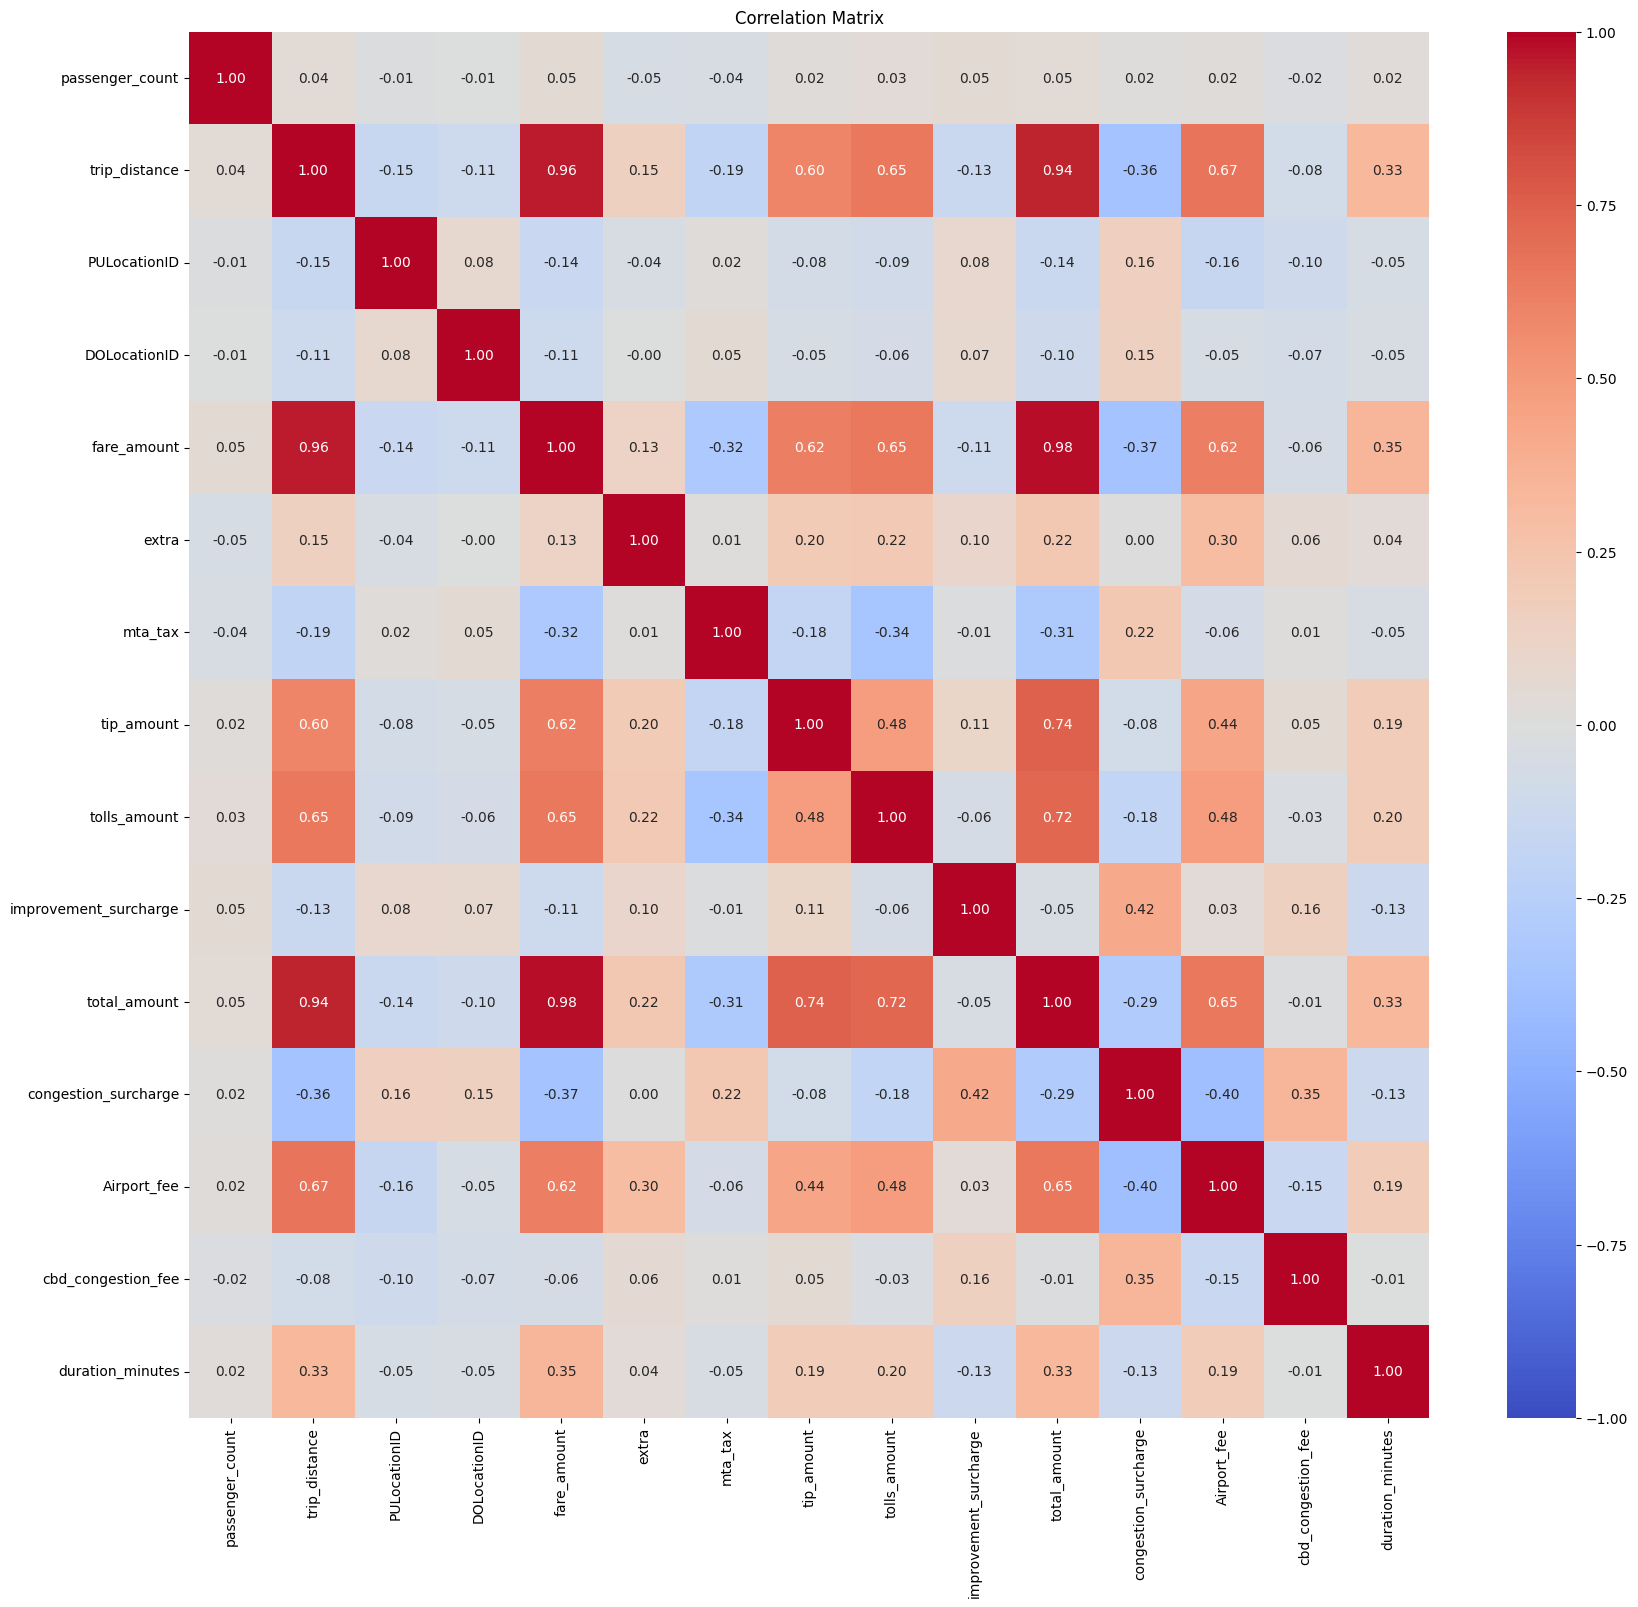

In [26]:
# matrice de correlation pour avoir les relations entre les colonnes numériques

corr_array = corr_matrix.head()[0].toArray()


corr_df = pd.DataFrame(
    corr_array,
    columns=numerical_cols,
    index=numerical_cols
)

plt.figure(figsize=(20,18))
sns.heatmap(
    corr_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Correlation Matrix")
plt.show()

In [27]:
df_numerical = df.select("trip_distance", "fare_amount", "tip_amount", "tolls_amount", "total_amount", "Airport_fee")
df_numerical.show(5)

+-------------+-----------+----------+------------+------------+-----------+
|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|Airport_fee|
+-------------+-----------+----------+------------+------------+-----------+
|          1.6|       10.0|       3.0|         0.0|        18.0|        0.0|
|          0.5|        5.1|      2.02|         0.0|       12.12|        0.0|
|          0.6|        5.1|       2.0|         0.0|        12.1|        0.0|
|         0.52|        7.2|       0.0|         0.0|         9.7|        0.0|
|         0.66|        5.8|       0.0|         0.0|         8.3|        0.0|
+-------------+-----------+----------+------------+------------+-----------+
only showing top 5 rows


In [28]:
columns = ["VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type","pickup_hour","day_of_week","month"]
df_categorical = df.select("VendorID", "RatecodeID", "store_and_fwd_flag", "payment_type","pickup_hour","day_of_week","month", "duration_minutes")

In [29]:
df_categorical.show()

+--------+----------+------------------+------------+-----------+-----------+-----+------------------+
|VendorID|RatecodeID|store_and_fwd_flag|payment_type|pickup_hour|day_of_week|month|  duration_minutes|
+--------+----------+------------------+------------+-----------+-----------+-----+------------------+
|       1|         1|                 N|           1|          0|          4|    1|              8.35|
|       1|         1|                 N|           1|          0|          4|    1|              2.55|
|       1|         1|                 N|           1|          0|          4|    1|              1.95|
|       2|         1|                 N|           2|          0|          4|    1| 5.566666666666666|
|       2|         1|                 N|           2|          0|          4|    1| 3.533333333333333|
|       2|         1|                 N|           2|          0|          4|    1|20.033333333333335|
|       2|         1|                 N|           2|          0|        

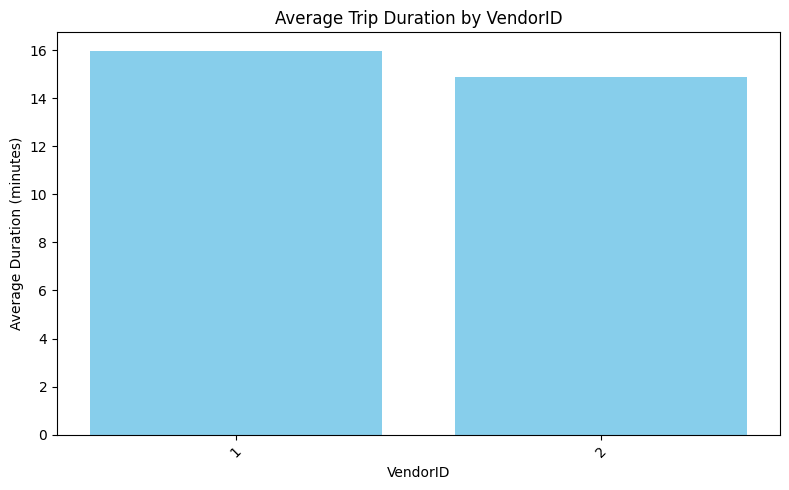

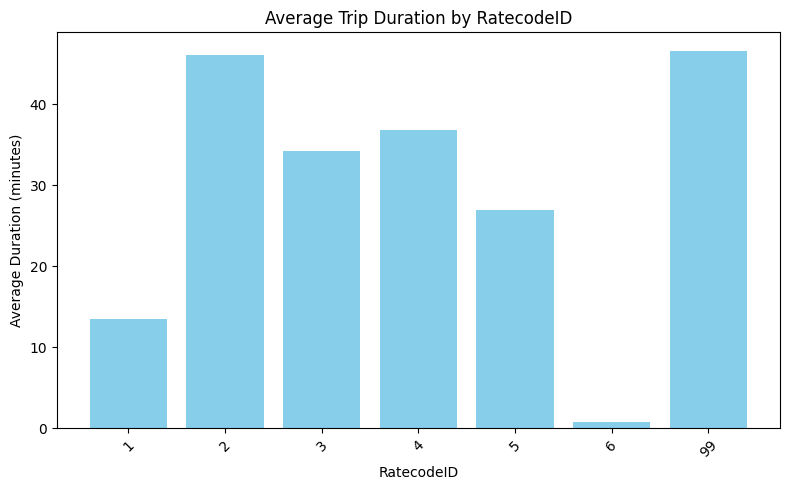

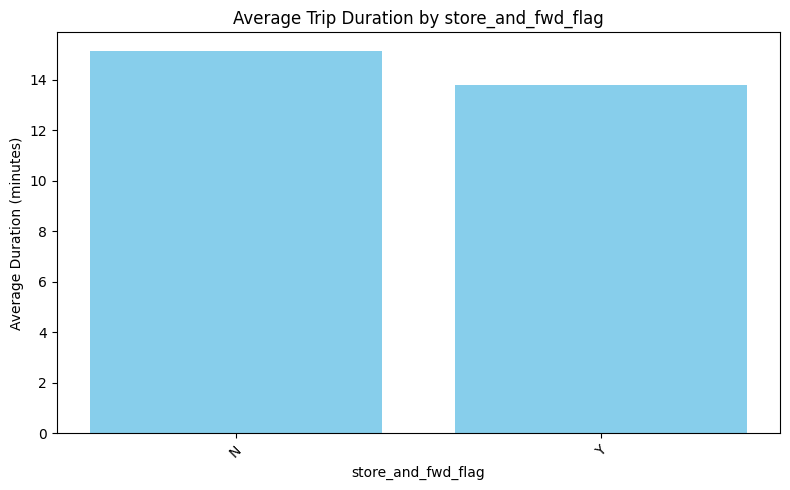

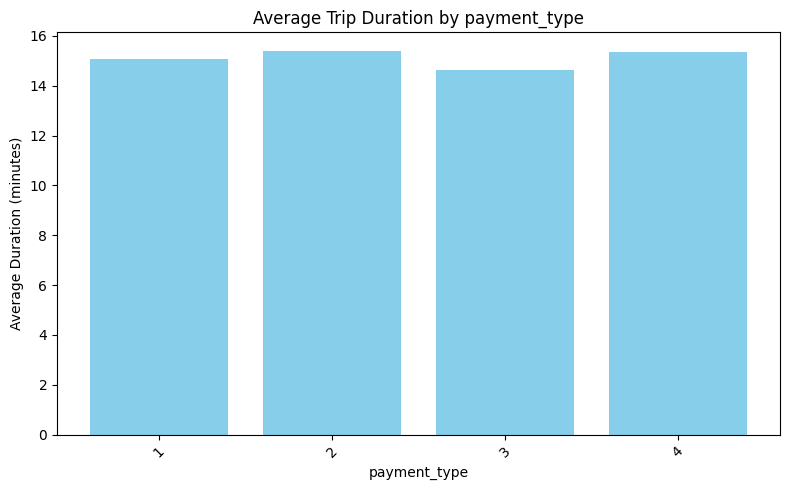

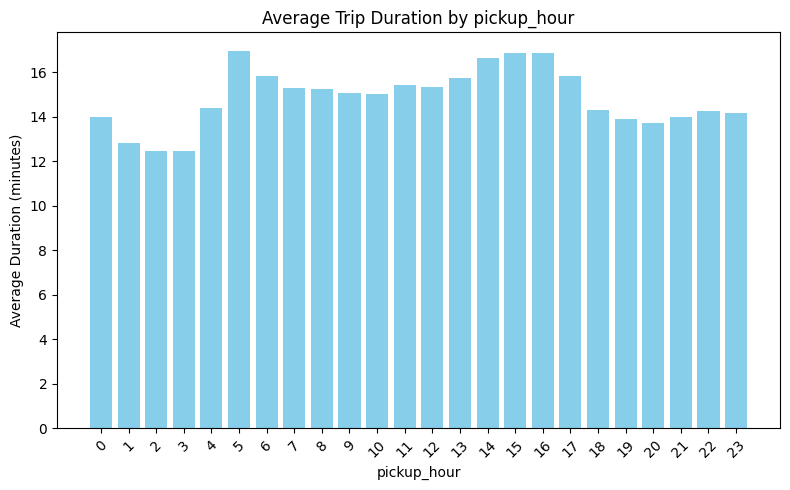

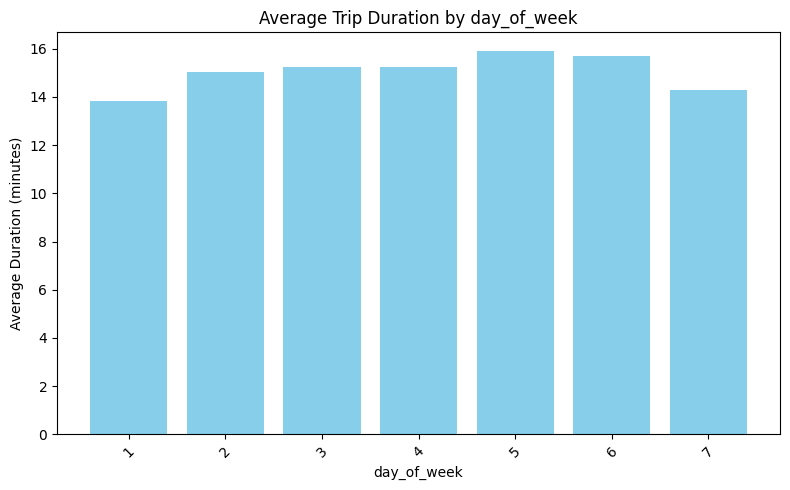

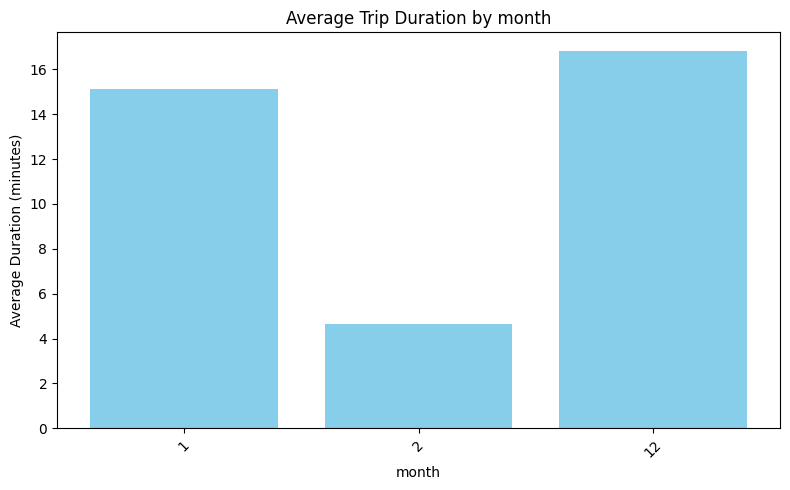

In [30]:

for c in columns:
    # Agrégation Spark
    agg_df = (
        df.groupBy(c)
          .agg(avg("duration_minutes").alias("avg_duration"))
          .orderBy(c)
    )

    # Conversion vers pandas et renommer la colonne pour éviter tout conflit
    pdf = agg_df.toPandas().rename(columns={c: "col"})

    # Plot
    plt.figure(figsize=(8,5))
    plt.bar(pdf["col"].astype(str), pdf["avg_duration"], color='skyblue')
    plt.xlabel(c)
    plt.ylabel("Average Duration (minutes)")
    plt.title(f"Average Trip Duration by {c}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [31]:
categorical = ["RateCodeID", "pickup_hour", "day_of_week"]
df_cat = df.select("RateCodeID", "pickup_hour", "day_of_week")

In [32]:
def combine_columns(df, categorical_cols, numerical_cols, target_col):
    all_cols = categorical_cols + numerical_cols + [target_col]
    return df.select(*all_cols)


df_silver = combine_columns(df, df_cat.columns, df_numerical.columns, "duration_minutes")
df_silver.show(5)

+----------+-----------+-----------+-------------+-----------+----------+------------+------------+-----------+-----------------+
|RateCodeID|pickup_hour|day_of_week|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|Airport_fee| duration_minutes|
+----------+-----------+-----------+-------------+-----------+----------+------------+------------+-----------+-----------------+
|         1|          0|          4|          1.6|       10.0|       3.0|         0.0|        18.0|        0.0|             8.35|
|         1|          0|          4|          0.5|        5.1|      2.02|         0.0|       12.12|        0.0|             2.55|
|         1|          0|          4|          0.6|        5.1|       2.0|         0.0|        12.1|        0.0|             1.95|
|         1|          0|          4|         0.52|        7.2|       0.0|         0.0|         9.7|        0.0|5.566666666666666|
|         1|          0|          4|         0.66|        5.8|       0.0|         0.0|    

In [ ]:
categorical_cols = [
    "RatecodeID",
    "pickup_hour",
    "day_of_week",
]

numerical_cols = [
    "trip_distance",
    "fare_amount",
    "tip_amount",
    "tolls_amount",
    "total_amount",
    "Airport_fee"
]

target_col = "duration_minutes"


In [34]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in categorical_cols
]

encoders = [
    OneHotEncoder(
        inputCol=f"{c}_idx",
        outputCol=f"{c}_ohe"
    )
    for c in categorical_cols
]

In [35]:
from pyspark.ml.feature import VectorAssembler

feature_cols = numerical_cols + [f"{c}_ohe" for c in categorical_cols]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

In [36]:
train_df, test_df = df_silver.randomSplit([0.8, 0.2], seed=42)

In [37]:
from pyspark.ml.regression import GBTRegressor

model = GBTRegressor(
    featuresCol="features",
    labelCol=target_col,
    maxIter=50,
    maxDepth=5
)

In [38]:
from pyspark.ml import Pipeline

pipeline = Pipeline(
    stages=indexers + encoders + [assembler, model]
)

pipeline_model = pipeline.fit(train_df)

26/01/16 12:49:03 WARN MemoryStore: Not enough space to cache rdd_259_3 in memory! (computed 27.0 MiB so far)
26/01/16 12:49:03 WARN MemoryStore: Not enough space to cache rdd_259_5 in memory! (computed 27.0 MiB so far)
26/01/16 12:49:03 WARN BlockManager: Persisting block rdd_259_5 to disk instead.
26/01/16 12:49:03 WARN BlockManager: Persisting block rdd_259_3 to disk instead.
26/01/16 12:49:03 WARN MemoryStore: Not enough space to cache rdd_259_1 in memory! (computed 27.0 MiB so far)
26/01/16 12:49:03 WARN BlockManager: Persisting block rdd_259_1 to disk instead.
26/01/16 12:49:22 WARN MemoryStore: Not enough space to cache rdd_259_3 in memory! (computed 145.8 MiB so far)
26/01/16 12:49:24 WARN MemoryStore: Not enough space to cache rdd_259_1 in memory! (computed 145.8 MiB so far)
26/01/16 12:49:24 WARN MemoryStore: Not enough space to cache rdd_259_3 in memory! (computed 1544.1 KiB so far)
26/01/16 12:49:25 WARN MemoryStore: Not enough space to cache rdd_259_1 in memory! (computed 

In [39]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = pipeline_model.transform(test_df)

evaluator = RegressionEvaluator(
    labelCol=target_col,
    predictionCol="prediction",
    metricName="rmse"
)

rmse = evaluator.evaluate(predictions)
print(f"RMSE: {rmse}")
for metric in ["mae", "r2"]:
    evaluator.setMetricName(metric)
    print(metric, evaluator.evaluate(predictions))

RMSE: 27.71775760456961


mae 2.456327522210604


r2 0.14161003342951117


In [40]:
pipeline_model.write().overwrite().save("smart_logitrack_pipeline")

In [41]:
df.write \
  .format("jdbc") \
  .option("url", "jdbc:postgresql://localhost:5432/smart_logitrack") \
  .option("dbtable", "silver_data") \
  .option("user", "postgres") \
  .option("password", "0000") \
  .option("driver", "org.postgresql.Driver") \
  .mode("overwrite") \
  .save()

Py4JJavaError: An error occurred while calling o2472.save.
: java.lang.ClassNotFoundException: org.postgresql.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:47)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:112)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:112)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:112)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:276)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:280)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:57)
	at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:55)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:79)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:77)
	at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:88)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$2(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:176)
	at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:284)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:138)
	at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
	at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
	at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
	at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:138)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:307)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:137)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:91)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:249)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:185)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:717)
	at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:184)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:201)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:194)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:491)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:107)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:491)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:467)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:194)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:155)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1392)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1453)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:160)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:239)
	at org.apache.spark.sql.classic.DataFrameWriter.runCommand(DataFrameWriter.scala:592)
	at org.apache.spark.sql.classic.DataFrameWriter.save(DataFrameWriter.scala:126)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
		at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
		at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
		at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:47)
		at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:112)
		at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:112)
		at scala.Option.foreach(Option.scala:437)
		at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:112)
		at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:276)
		at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:280)
		at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:57)
		at org.apache.spark.sql.execution.datasources.SaveIntoDataSourceCommand.run(SaveIntoDataSourceCommand.scala:55)
		at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult$lzycompute(commands.scala:79)
		at org.apache.spark.sql.execution.command.ExecutedCommandExec.sideEffectResult(commands.scala:77)
		at org.apache.spark.sql.execution.command.ExecutedCommandExec.executeCollect(commands.scala:88)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$2(QueryExecution.scala:185)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$8(SQLExecution.scala:176)
		at org.apache.spark.sql.execution.SQLExecution$.withSessionTagsApplied(SQLExecution.scala:284)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$7(SQLExecution.scala:138)
		at org.apache.spark.JobArtifactSet$.withActiveJobArtifactState(JobArtifactSet.scala:94)
		at org.apache.spark.sql.artifact.ArtifactManager.$anonfun$withResources$1(ArtifactManager.scala:112)
		at org.apache.spark.sql.artifact.ArtifactManager.withClassLoaderIfNeeded(ArtifactManager.scala:106)
		at org.apache.spark.sql.artifact.ArtifactManager.withResources(ArtifactManager.scala:111)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$6(SQLExecution.scala:138)
		at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:307)
		at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId0$1(SQLExecution.scala:137)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId0(SQLExecution.scala:91)
		at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:249)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$eagerlyExecuteCommands$1(QueryExecution.scala:185)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:717)
		at org.apache.spark.sql.execution.QueryExecution.org$apache$spark$sql$execution$QueryExecution$$eagerlyExecute$1(QueryExecution.scala:184)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:201)
		at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$3.applyOrElse(QueryExecution.scala:194)
		at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:491)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:107)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:491)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:360)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:356)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:467)
		at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:194)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyCommandExecuted$1(QueryExecution.scala:155)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1392)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 17 more


In [ ]:
# import os
# from dotenv import load_dotenv

# #  Charger les variables d'environnement
# load_dotenv()


# db_user = os.getenv("USER_DB")
# db_password = os.getenv("PASSWORD")
# db_name = "smart_logitrack"


# db_host = "localhost" 

# properties = {
#     "user": db_user,
#     "password": db_password,
#     "driver": "org.postgresql.Driver"
# }

# table_name = "silver_data" 

# try:
    
#     jdbc_url = f"jdbc:postgresql://{db_host}:5432/{db_name}"
    
#     #  Sauvegarde
#     df_silver.write.jdbc(
#         url=jdbc_url, 
#         table=table_name, 
#         mode="overwrite", 
#         properties=properties
#     )
#     print(f" Données sauvegardées avec succès dans la table '{table_name}'")

# except Exception as e:
#     print(f" Erreur lors de la sauvegarde : {e}")
#     print(" Conseil : Vérifie que le conteneur Postgres est allumé et que le driver JDBC est chargé.")

 Erreur lors de la sauvegarde : An error occurred while calling o2447.jdbc.
: java.lang.ClassNotFoundException: org.postgresql.Driver
	at java.base/java.net.URLClassLoader.findClass(URLClassLoader.java:445)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:592)
	at java.base/java.lang.ClassLoader.loadClass(ClassLoader.java:525)
	at org.apache.spark.sql.execution.datasources.jdbc.DriverRegistry$.register(DriverRegistry.scala:47)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1(JDBCOptions.scala:112)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.$anonfun$driverClass$1$adapted(JDBCOptions.scala:112)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCOptions.<init>(JDBCOptions.scala:112)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions.scala:276)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcOptionsInWrite.<init>(JDBCOptions